## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(3143)
# np.random.seed(54325)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 5 # true number of clusters

info_x = 0.3 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 10 



observed mixture proportions: 
 [ 0.204  0.201  0.175  0.208  0.212]
true mixture proportions: 
 [ 0.2  0.2  0.2  0.2  0.2]


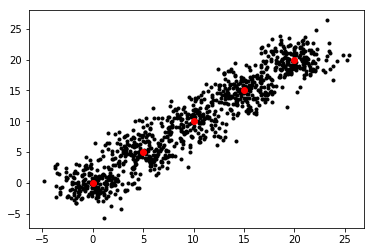

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

## Initialize

In [7]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_free_params = vb_params.get_free()
global_init_free_params = vb_params['global'].get_free()

## Run CAVI 

CAVI terminated successfully :)
iterations ran:  629
elbo:  -44695.5287601


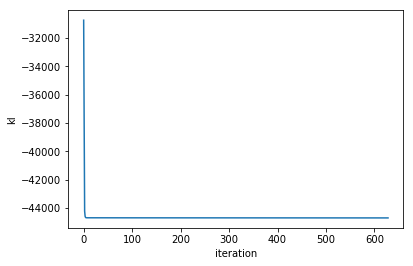

In [8]:
dp_opt.run_cavi(model, init_free_params, max_iter = 1000, tol = 1e-5, disp = False)
cavi_results = deepcopy(model)
print('elbo: ', cavi_results.get_kl())


### examine results of CAVI

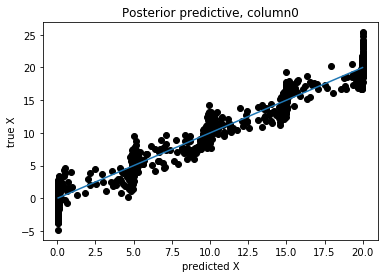

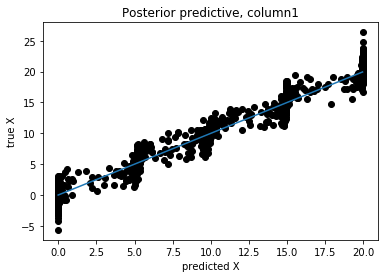

In [9]:
# plot posterior predictive
e_z = cavi_results.vb_params['local']['e_z'].get()
mu = cavi_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = cavi_results.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights 

print('true number of clusters: ', k_true)
print('number of "posterior clusters" (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.2  0.2  0.2  0.2  0.2]
estimated proportions:  [ 0.00103921  0.19411039  0.02098208  0.03772041  0.00103388  0.20613063
  0.0010304   0.21145813  0.20225867  0.12423618] 

true number of clusters:  5
number of "posterior clusters" (ie. no. clusters w/ siginifcant weights):  5
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
print(cavi_results.vb_params['global']['mu'].get()[heavy_clusters, :])

true means: 
[[ 0  0]
 [ 5  5]
 [10 10]
 [15 15]
 [20 20]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[  4.92424825e+00   5.10055368e+00]
 [  1.49641772e+01   1.49151451e+01]
 [  1.99869378e+01   1.99373862e+01]
 [  6.56068591e-02  -1.16303037e-02]
 [  9.85546129e+00   9.58329301e+00]]


## Newton Optimization

In [12]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [13]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-8, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hessp=kl_obj.fun_free_hvp,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done :o')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
newton_tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton

         Current function value: -44695.529510
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 6
         Hessian evaluations: 0
done :o


In [14]:
model.vb_params['global'].set_free(newton_tr_opt.x)
model.set_optimal_z()

newton_results = deepcopy(model)

In [15]:
# checking the optima

print('minimizing function value', newton_results.get_kl())

# check that the gradient is close to 0
kl_grad = kl_obj.fun_free_grad(newton_tr_opt.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj.fun_free_hessian(newton_tr_opt.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian eigenvalues all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

minimizing function value -44695.5295212
L_inf norm of gradient:  8.51876792589e-08
time to compute Hessian (sec):  9.264599084854126
Hessian eigenvalues all positive:  True
distance (l2) to minimizer of quadratic approx. :  4.76060169851e-07


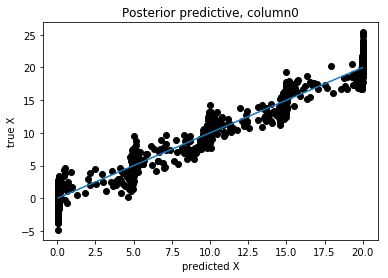

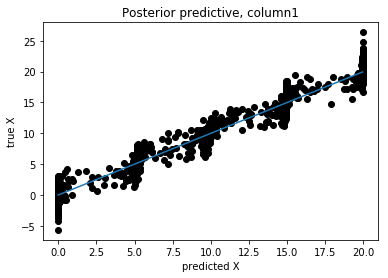

In [16]:
# plot posterior predictive
e_z = newton_results.vb_params['local']['e_z'].get()
mu = newton_results.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [17]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(newton_results.vb_params['global']['mu'].get())

print('l1 difference (normalized) between means: ', \
      np.mean(np.abs(cavi_results.vb_params['global']['mu'].get() \
                     - newton_results.vb_params['global']['mu'].get())))

[[  1.01031033e+01   1.01278452e+01]
 [  4.92424825e+00   5.10055368e+00]
 [  7.30974527e+00   8.99240720e+00]
 [  1.09446142e+01   1.16327411e+01]
 [  1.01031044e+01   1.01278389e+01]
 [  1.49641772e+01   1.49151451e+01]
 [  1.01031051e+01   1.01278348e+01]
 [  1.99869378e+01   1.99373862e+01]
 [  6.56068591e-02  -1.16303037e-02]
 [  9.85546129e+00   9.58329301e+00]]
[[  1.01031295e+01   1.01279526e+01]
 [  4.92489569e+00   5.10059584e+00]
 [  7.31584399e+00   8.98171793e+00]
 [  1.09780920e+01   1.16852485e+01]
 [  1.01031304e+01   1.01279455e+01]
 [  1.49639807e+01   1.49148974e+01]
 [  1.01031310e+01   1.01279408e+01]
 [  1.99868923e+01   1.99373443e+01]
 [  6.56454244e-02  -1.15687335e-02]
 [  9.86836634e+00   9.60723031e+00]]
l1 difference (normalized) between means:  0.00706674968295


In [18]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - newton_results.vb_params.get_free())))

l1 difference (normalized) between all params:  0.0293318575826


## Parametric sensitivity analysis
In particular, we are interested in the sensitivity of the posterior stick lengths to our choice of DP parameter $\alpha$

In [19]:
class DPNormalMixtureLRVB(object): 
    def __init__(self, model): 
        self.model = deepcopy(model)
        self.alpha = model.alpha
        
        self.get_moment_jac = autograd.jacobian(self.get_interesting_moments)        
        self.get_kl_hessian = autograd.hessian(self.kl, argnum = 0)
        
        self.get_kl_jac = autograd.jacobian(self.kl, argnum = 0)
        self.get_alpha_jac = autograd.jacobian(self.get_kl_jac, argnum = 1)
        
    def get_interesting_moments(self, global_free_params):
        self.model.vb_params['global'].set_free(global_free_params)  
        
        # returning average of the v_sticks
        return self.model.vb_params['global']['v_sticks'].e()[:,0]
    
    def kl(self, global_free_params, alpha):
        self.model.vb_params['global'].set_free(global_free_params)
        self.model.alpha = alpha
        
        return self.model.kl_optimize_z()
    
    def get_alpha_sensitivity(self, optimal_global_free_params): 
        moment_jac = self.get_moment_jac(optimal_global_free_params)
        kl_hessian = self.get_kl_hessian(optimal_global_free_params, self.alpha)
        
        sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
                                               
        alpha_jac = self.get_alpha_jac(optimal_global_free_params, self.alpha)

        return np.dot(sensitivity_operator.T, -1 * alpha_jac)



In [20]:
lrvb_obj = DPNormalMixtureLRVB(model)

In [21]:
print('sensitivity of mean stick lengths to alpha: ')
predicted_sensitivity = lrvb_obj.get_alpha_sensitivity(newton_tr_opt.x)

print('predicted_sensitivity: \n', predicted_sensitivity)

sensitivity of mean stick lengths to alpha: 
predicted_sensitivity: 
 [ -1.48227291e-06   8.47541356e-04  -6.96248615e-03  -2.41424285e-02
  -4.52759512e-05  -9.27493799e-03  -8.66367437e-05  -1.76071264e-02
  -4.50220947e-02]


### Lets check this sensitivity by perturbing alpha

In [22]:
epsilon = .1 # how much we will perturb alpha

model_perturbed = deepcopy(model)
model_perturbed.alpha = alpha + epsilon # perturb dp parameter

# define new objective
kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

# find new optima
newton_tr_opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6))


         Current function value: -44695.322991
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 6
         Hessian evaluations: 0
done :o


In [23]:
# checking the optima

# check that the gradient is close to 0
kl_grad = kl_obj_perturbed.fun_free_grad(newton_tr_opt_perturbed.x)
# print(kl_grad)
print('L_inf norm of gradient: ', np.max(np.abs(kl_grad)))

t0 = time.time()
kl_hessian = kl_obj_perturbed.fun_free_hessian(newton_tr_opt_perturbed.x)
hessian_time = time.time() - t0

hessian_evals = np.linalg.eigvals(kl_hessian)

print('time to compute Hessian (sec): ', hessian_time)
# print('eigenvalues: \n', hessian_evals)
print('Hessian evals all positive: ', np.all(hessian_evals > 0))
print('distance (l2) to minimizer of quadratic approx. : ', np.linalg.norm(-np.linalg.solve(kl_hessian, kl_grad)))

L_inf norm of gradient:  6.37522507494e-07
time to compute Hessian (sec):  8.109593629837036
Hessian evals all positive:  True
distance (l2) to minimizer of quadratic approx. :  3.23240096169e-06


In [24]:
# check new means
model_perturbed.vb_params['global'].set_free(newton_tr_opt_perturbed.x) 

perturbed_mean = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
old_mean = model.vb_params['global']['v_sticks'].e()[:,0]

print('predicted_sensitivity: \n', predicted_sensitivity)
print('true sensitivity: \n', (perturbed_mean - old_mean) / epsilon)

predicted_sensitivity: 
 [ -1.48227291e-06   8.47541356e-04  -6.96248615e-03  -2.41424285e-02
  -4.52759512e-05  -9.27493799e-03  -8.66367437e-05  -1.76071264e-02
  -4.50220947e-02]
true sensitivity: 
 [ -1.48296072e-06   7.87699845e-04  -6.52132044e-03  -2.15824211e-02
  -4.09459849e-05  -8.30971760e-03  -7.80537862e-05  -1.58372567e-02
  -4.03963483e-02]


### Let us check the linearity of the perturbation in alpha

In [28]:
epsilons = np.arange(-0.5, 0.5, 0.1) # the range with which we will evaluate alpha


opt_perturbed = deepcopy(newton_tr_opt)

perturbed_means = np.zeros((len(epsilons), k_approx - 1))

for i in range(len(epsilons)): 
    print(epsilons[i])
    model_perturbed = deepcopy(model)
    model_perturbed.alpha  = alpha + epsilons[i] # perturb dp parameter

    # define new objective
    kl_obj_perturbed = Objective(model_perturbed.vb_params['global'], model_perturbed.kl_optimize_z)

    # find new optima
    opt_perturbed = minimize_kl(kl_obj_perturbed, newton_tr_opt.x, gtol = 10**(-6), disp = False)
    
    # check new means
    model_perturbed.vb_params['global'].set_free(opt_perturbed.x) 

    perturbed_means[i, :] = model_perturbed.vb_params['global']['v_sticks'].e()[:,0]
    print('true sensitivity: \n', (perturbed_means[i, :] - old_mean) / (epsilon[i]))
    

-0.5
done :o
true sensitivity: 
 [ -9.99113083e-07   3.93357398e-03  -6.16900970e-02  -1.86723589e-01
  -3.92972734e-04  -8.46470561e-02  -8.09897888e-04  -1.67342504e-01
  -4.95879093e-01]
-0.4
done :o
true sensitivity: 
 [ -1.26413703e-06   3.44179523e-03  -3.04969262e-02  -1.30900515e-01
  -2.41986318e-04  -5.25349264e-02  -4.84819064e-04  -1.00026532e-01
  -2.73465570e-01]
-0.3
done :o
true sensitivity: 
 [ -1.46765471e-06   1.33675064e-03  -1.03898076e-02  -4.40825797e-02
  -7.92471099e-05  -1.68224596e-02  -1.54256308e-04  -3.15839022e-02
  -8.19900308e-02]
-0.2
done :o
true sensitivity: 
 [ -1.47875909e-06   1.06876237e-03  -8.51916885e-03  -3.32940941e-02
  -6.07740823e-05  -1.27242549e-02  -1.17424601e-04  -2.39683132e-02
  -6.17539837e-02]
-0.1
done :o
true sensitivity: 
 [ -1.48182205e-06   9.33089891e-04  -7.57291785e-03  -2.77259677e-02
  -5.13321842e-05  -1.06244181e-02  -9.86555496e-05  -2.00897126e-02
  -5.15327346e-02]
-1.11022302463e-16
done :o
true sensitivity: 
 [-0

In [ ]:
predicted_sensitivity: 
  [ -1.48227291e-06   8.47541356e-04  -6.96248615e-03  -2.41424285e-02
  -4.52759512e-05  -9.27493799e-03  -8.66367437e-05  -1.76071264e-02
  -4.50220947e-02]


ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

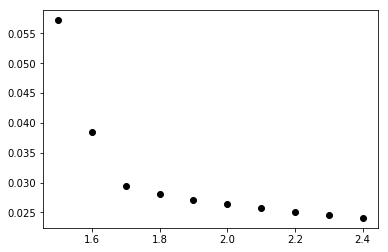

In [29]:
k = 2 # choose your stick

# plot posterior v_sticks against alpha
plt.plot(alpha + epsilon, perturbed_means[:, k], 'ko')

# plot the LRVB approximation
x_axis = np.linspace(alpha + epsilon[0], alpha + epsilon[-1], 100)
plt.plot(x_axis, predicted_sensitivity[k] * (epsilon) + old_mean[k])
plt.xlabel('alpha')
plt.ylabel('posterior stick length')